In [129]:
import os
import sys
import pandas as pd
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import category_encoders as ce
from category_encoders import TargetEncoder
import numpy as np
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Assuming the notebook is in 'notebooks/' and the project root is one level up
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to sys.path if it's not already there
if project_root not in sys.path:
    sys.path.append(project_root)

# Verify the path has been added (optional)
print(f"Project root added to sys.path: {project_root}")

Project root added to sys.path: d:\Projects\EDA-Clustering-Time-series---Regression-Model-Airbnb-Data


In [89]:
from database import get_sqlalchemy_engine
engine = get_sqlalchemy_engine()

✅ Successfully connected to SQL Server via pyodbc.
✅ SQLAlchemy engine created successfully.


✅ Loaded 1178740 rows.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1178740 entries, 0 to 1178739
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   listing_id              1178740 non-null  int64  
 1   total_weeks             1178740 non-null  int64  
 2   offline_weeks           1178740 non-null  int64  
 3   pct_offline_weeks       1178740 non-null  float64
 4   mean_availability       1178740 non-null  float64
 5   first_week              1178740 non-null  object 
 6   last_week               1178740 non-null  object 
 7   base_price              996981 non-null   float64
 8   number_of_reviews       1178740 non-null  int64  
 9   property_city           1178740 non-null  object 
 10  property_country        1178740 non-null  object 
 11  property_neighbourhood  1178740 non-null  object 
 12  latitude                1178740 non-null  float64
 13  longitude               1178740 no

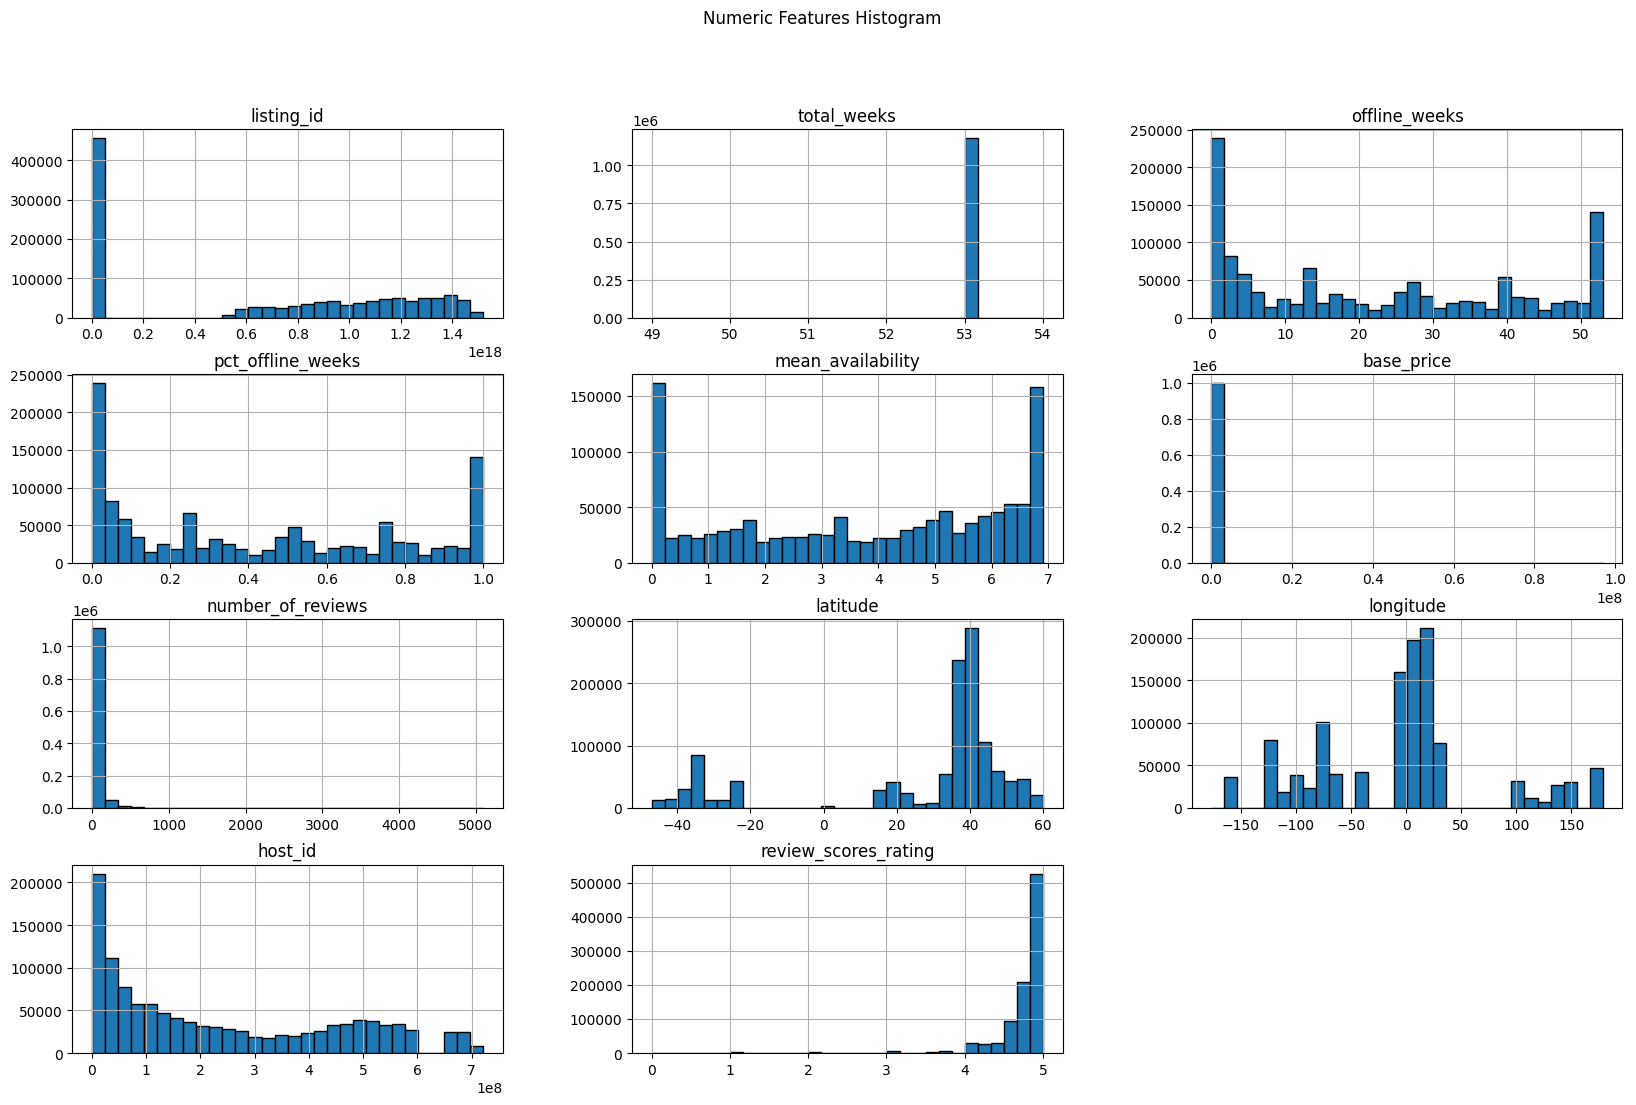

In [90]:
# Load full table
query = "SELECT * FROM listing_features"
df = pd.read_sql(query, engine)

print(f"✅ Loaded {len(df)} rows.")
print(df.info())
print(df.describe(include='all'))

# Check missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Numeric distributions
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
print("\nNumeric feature distributions:")
df[numeric_cols].hist(figsize=(20, 12), bins=30, edgecolor='k')
plt.suptitle("Numeric Features Histogram")
plt.show()

In [91]:
# Filter dataset
df_filtered = df[
    (df['base_price'].notna()) &          # base_price is not null
    (df['base_price'] > 0) &             # base_price > 0
    (df['pct_offline_weeks'] < 1)        # not offline 100% of the year
].copy()

print(f"✅ Filtered dataset: {len(df_filtered)} rows remaining.")
print(df_filtered[['listing_id', 'base_price', 'pct_offline_weeks']].head())

✅ Filtered dataset: 986250 rows remaining.
   listing_id  base_price  pct_offline_weeks
0         360       139.0           0.622642
1         364       179.0           0.018868
2         592        68.0           0.301887
3         686        42.0           0.622642
4         958       157.0           0.188679


In [92]:


print(f"✅ Loaded {len(df_filtered)} rows.")
print(df_filtered.info())
print(df_filtered.describe(include='all'))

✅ Loaded 986250 rows.
<class 'pandas.core.frame.DataFrame'>
Index: 986250 entries, 0 to 1178738
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   listing_id              986250 non-null  int64  
 1   total_weeks             986250 non-null  int64  
 2   offline_weeks           986250 non-null  int64  
 3   pct_offline_weeks       986250 non-null  float64
 4   mean_availability       986250 non-null  float64
 5   first_week              986250 non-null  object 
 6   last_week               986250 non-null  object 
 7   base_price              986250 non-null  float64
 8   number_of_reviews       986250 non-null  int64  
 9   property_city           986250 non-null  object 
 10  property_country        986250 non-null  object 
 11  property_neighbourhood  986250 non-null  object 
 12  latitude                986250 non-null  float64
 13  longitude               986250 non-null  float64
 14  ho

In [93]:
# Top 20 highest prices
top_prices = df_filtered[['listing_id', 'property_city', 'base_price']].sort_values(by='base_price', ascending=False).head(20)
print("🔥 Top 20 extreme prices:")
display(top_prices)


🔥 Top 20 extreme prices:


,listing_id,property_city,base_price
689678,939166695586608420,Santiago,96927884.0
472833,585611679710850418,Buenos Aires,63013022.0
873527,1171835238649898320,Buenos Aires,61920797.0
873476,1171797727387603815,Buenos Aires,61920797.0
627599,863708705635094490,Buenos Aires,60012405.0
514227,663791921269219889,Buenos Aires,52773406.0
514226,663791437064459738,Buenos Aires,52773406.0
83767,12103264,Buenos Aires,52773406.0
102385,14228810,Buenos Aires,52773406.0
753822,1031975482740498353,Buenos Aires,47259767.0


In [94]:
# Bottom 20 lowest non-zero prices
bottom_prices = df_filtered[df_filtered['base_price'] > 0][['listing_id', 'property_city', 'base_price']].sort_values(by='base_price').head(20)
print("❄️ Bottom 20 extreme prices:")
display(bottom_prices)


❄️ Bottom 20 extreme prices:


,listing_id,property_city,base_price
324308,41406564,Singapore,1.0
788451,1078964503783527839,Madrid,1.0
953785,1259371487610970172,Puglia,2.0
1171511,1491347288120789351,Clark County,3.0
707019,962702059998563738,Taipei,5.0
707022,962708449640986686,Taipei,5.0
997295,1307078011285176782,Taipei,5.0
719480,981443881050069230,Taipei,5.0
216615,27716513,Berlin,5.0
620387,854126526077679617,Taipei,5.0


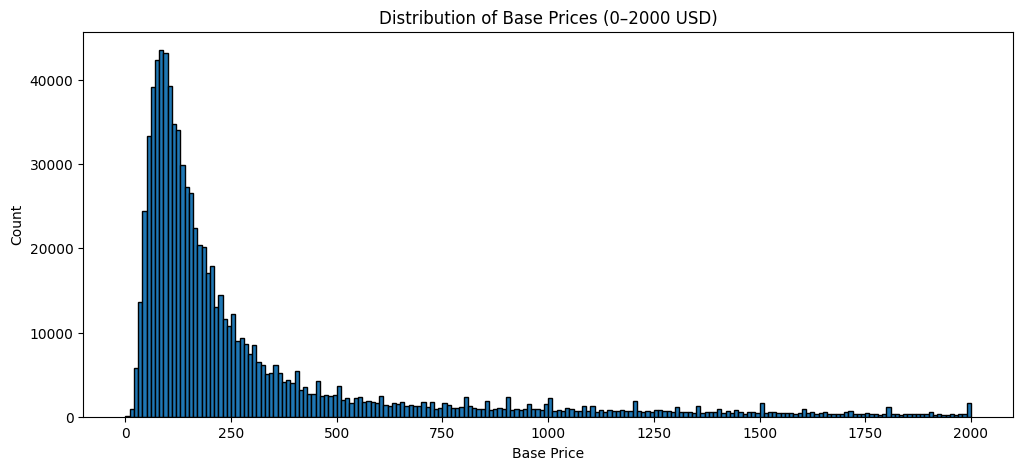

In [95]:


plt.figure(figsize=(12,5))
plt.hist(df_filtered['base_price'], bins=200, range=(0, 2000), edgecolor='k')  # focus on main range
plt.title("Distribution of Base Prices (0–2000 USD)")
plt.xlabel("Base Price")
plt.ylabel("Count")
plt.show()


In [96]:
# Count listings between 10 and 1000 USD
between_10_1000  = ((df_filtered['base_price'] >= 10) & (df_filtered['base_price'] <= 1000)).sum()
# Total listings
total_listings = len(df_filtered)

# Percentage
percentage_between_10_1000 = (between_10_1000 / total_listings) * 100

print(f"💰 Listings between 10$ and $1,000: {between_10_1000} / {total_listings} ({percentage_between_10_1000:.2f}%)")

💰 Listings between 10$ and $1,000: 793634 / 986250 (80.47%)


In [97]:
# Filter prices between $10 and $1000
df_filtered = df_filtered[(df_filtered['base_price'] >= 10) & (df_filtered['base_price'] <= 1000)].copy()

print(f"✅ Dataset after filtering outliers: {len(df_filtered)} rows remaining.")
print(df_filtered['base_price'].describe())


✅ Dataset after filtering outliers: 793634 rows remaining.
count    793634.000000
mean        213.621645
std         195.541437
min          10.000000
25%          88.000000
50%         144.000000
75%         257.000000
max        1000.000000
Name: base_price, dtype: float64


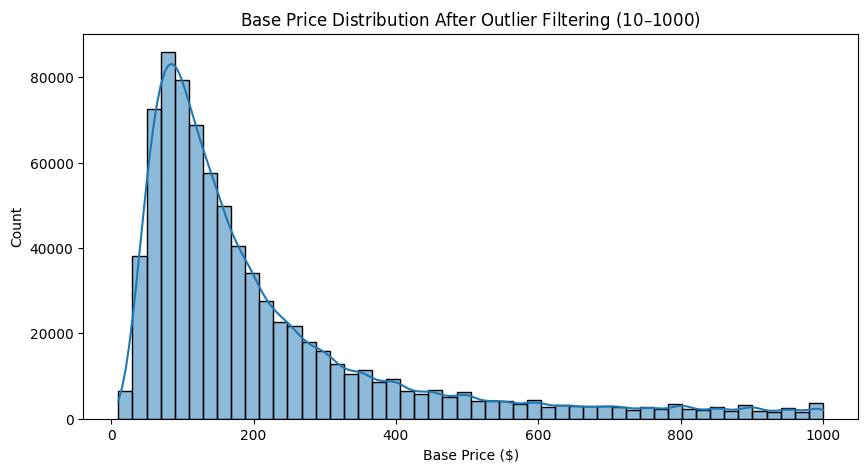

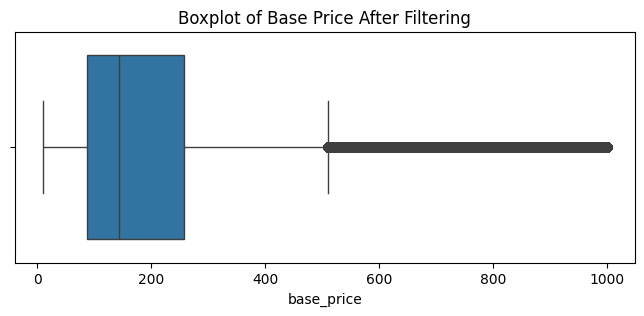

In [98]:


plt.figure(figsize=(10,5))
sns.histplot(df_filtered['base_price'], bins=50, kde=True)
plt.title("Base Price Distribution After Outlier Filtering ($10–$1000)")
plt.xlabel("Base Price ($)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8,3))
sns.boxplot(x=df_filtered['base_price'])
plt.title("Boxplot of Base Price After Filtering")
plt.show()


In [99]:


# Select key predictors (no latitude/longitude)
features = ['review_scores_rating', 'property_city', 'property_neighbourhood']

# Drop missing values
df_model = df_filtered.dropna(subset=features + ['base_price']).copy()

X = df_model[features]
y = df_model['base_price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
cat_features = ['property_city', 'property_neighbourhood']
num_features = ['review_scores_rating']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_features),
        ('num', 'passthrough', num_features)
    ]
)

# Build model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ))
])

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")


R² Score: 0.455
RMSE: 139.56


In [100]:
# Feature importances
rf = model.named_steps['regressor']
ohe = model.named_steps['preprocessor'].named_transformers_['cat']
cat_names = ohe.get_feature_names_out(cat_features)
feature_names = np.concatenate([cat_names, num_features])

importances = pd.DataFrame({
    'feature': feature_names,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(importances.head(20))


                              feature  importance
5422             review_scores_rating    0.138802
45          property_city_Mexico City    0.121941
5               property_city_Bangkok    0.105767
23           property_city_Copenhagen    0.100474
20            property_city_Cape Town    0.099198
56                 property_city_Oslo    0.053503
65       property_city_Rio de Janeiro    0.043674
35             property_city_Istanbul    0.023355
80            property_city_Stockholm    0.017358
32               property_city_Hawaii    0.015775
82               property_city_Taipei    0.013095
53          property_city_New Zealand    0.011992
8     property_city_Barwon South West    0.009550
42             property_city_Mallorca    0.009219
63         property_city_Rhode Island    0.008247
81       property_city_Sunshine Coast    0.008222
94    property_city_Western Australia    0.005431
9                property_city_Belize    0.004027
44              property_city_Menorca    0.003550


In [101]:
# Filter listings: keep only those available more than 20% of the year
df_active = df_filtered[df_filtered['pct_offline_weeks'] < 0.8].copy()

print(f"✅ Filtered active listings: {len(df_active)} / {len(df_filtered)} ({len(df_active)/len(df_filtered)*100:.2f}%) remain.")


✅ Filtered active listings: 719113 / 793634 (90.61%) remain.


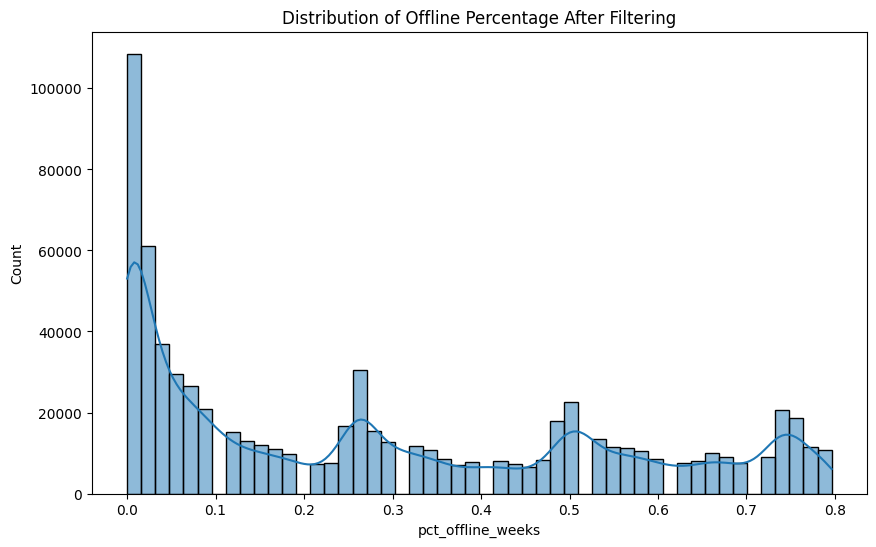

In [102]:
plt.figure(figsize=(10, 6))
sns.histplot(df_active['pct_offline_weeks'], bins=50, kde=True)
plt.title("Distribution of Offline Percentage After Filtering")
plt.xlabel("pct_offline_weeks")
plt.show()


count    398225.000000
mean          1.992929
std           8.173615
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        2675.000000
Name: count, dtype: float64


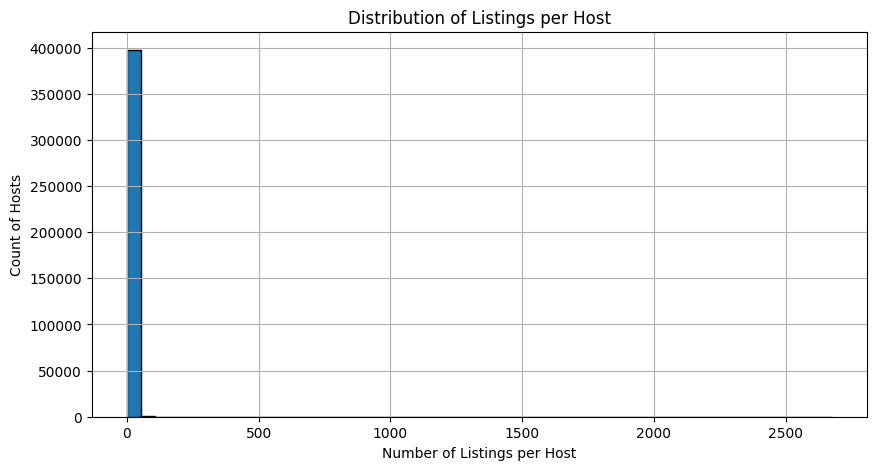

📊 74.21% of hosts have only one listing.


In [137]:
host_counts = df_filtered['host_id'].value_counts()

print(host_counts.describe())
plt.figure(figsize=(10,5))
host_counts.hist(bins=50, edgecolor='k')
plt.title("Distribution of Listings per Host")
plt.xlabel("Number of Listings per Host")
plt.ylabel("Count of Hosts")
plt.show()

# Percentage of hosts with 1 listing
single_listing_ratio = (host_counts == 1).mean() * 100
print(f"📊 {single_listing_ratio:.2f}% of hosts have only one listing.")


In [138]:
multi_hosts = host_counts[host_counts > 1]
print(f"Number of multi-listing hosts: {len(multi_hosts)}")
print(f"Total listings managed by multi-listing hosts: {multi_hosts.sum()}")


Number of multi-listing hosts: 102711
Total listings managed by multi-listing hosts: 498120


In [139]:

corr = df[['base_price', 'host_mean_price']].corr().iloc[0,1]
print(f"Correlation between base_price and host_mean_price: {corr:.3f}")

df[['host_mean_price', 'host_mean_rating', 'host_listing_count']].describe()


Correlation between base_price and host_mean_price: 0.927


,host_mean_price,host_mean_rating,host_listing_count
count,793634.000000,729363.000000,793634.000000
mean,213.621658,4.747706,35.515361
std,181.335297,0.312688,183.988031
min,10.000000,0.000000,1.000000
25%,95.000000,4.659250,1.000000
50%,152.000000,4.830000,3.000000
75%,264.000000,4.940000,10.000000
max,1000.000000,5.000000,2675.000000


In [ ]:
# Ensure available_weeks exists
if 'available_weeks' not in df_filtered.columns:
    df_filtered['available_weeks'] = df_filtered['total_weeks'] - df_filtered['offline_weeks']

# Now compute availability ratio
df_filtered['availability_ratio'] = df_filtered['available_weeks'] / df_filtered['total_weeks']



🚀 Training XGBoost...


C:\Users\yassi\AppData\Local\Temp\ipykernel_13116\2430230139.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp.head(10), palette='viridis')


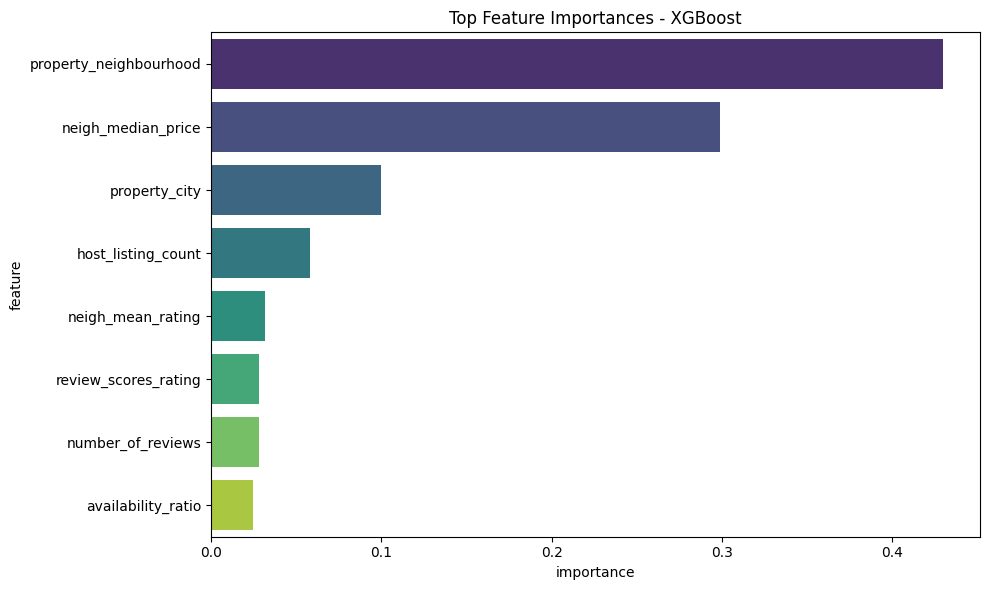


🚀 Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1566
[LightGBM] [Info] Number of data points in the train set: 634907, number of used features: 8
[LightGBM] [Info] Start training from score 5.049652


C:\Users\yassi\AppData\Local\Temp\ipykernel_13116\2430230139.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp.head(10), palette='viridis')


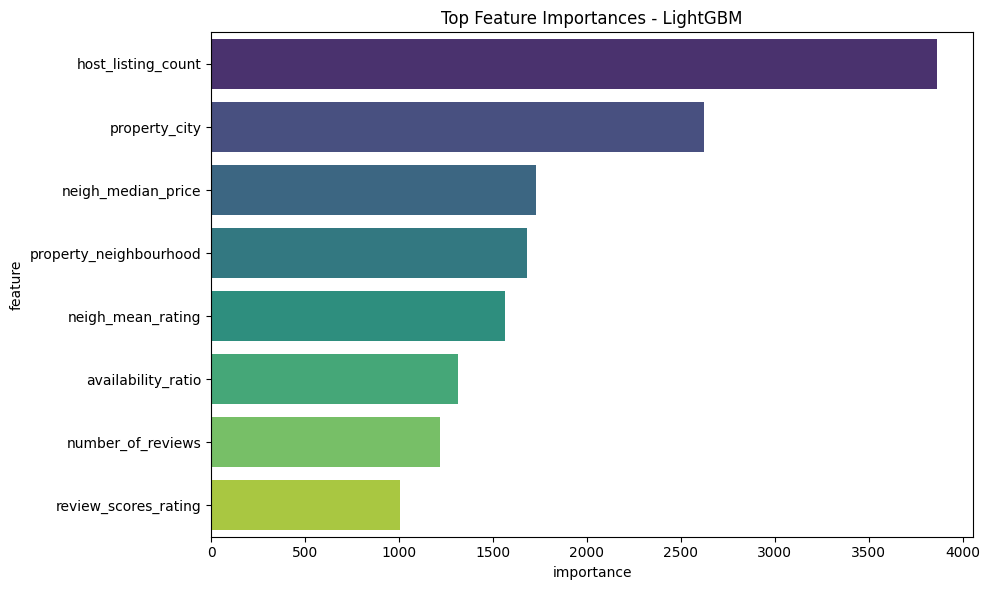


🚀 Training CatBoost...
0:	learn: 0.7638167	total: 49ms	remaining: 24.4s
100:	learn: 0.5660610	total: 4.86s	remaining: 19.2s
200:	learn: 0.5578694	total: 9.53s	remaining: 14.2s
300:	learn: 0.5525455	total: 14.2s	remaining: 9.38s
400:	learn: 0.5480943	total: 18.9s	remaining: 4.67s
499:	learn: 0.5446646	total: 23.6s	remaining: 0us


C:\Users\yassi\AppData\Local\Temp\ipykernel_13116\2430230139.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp.head(10), palette='viridis')


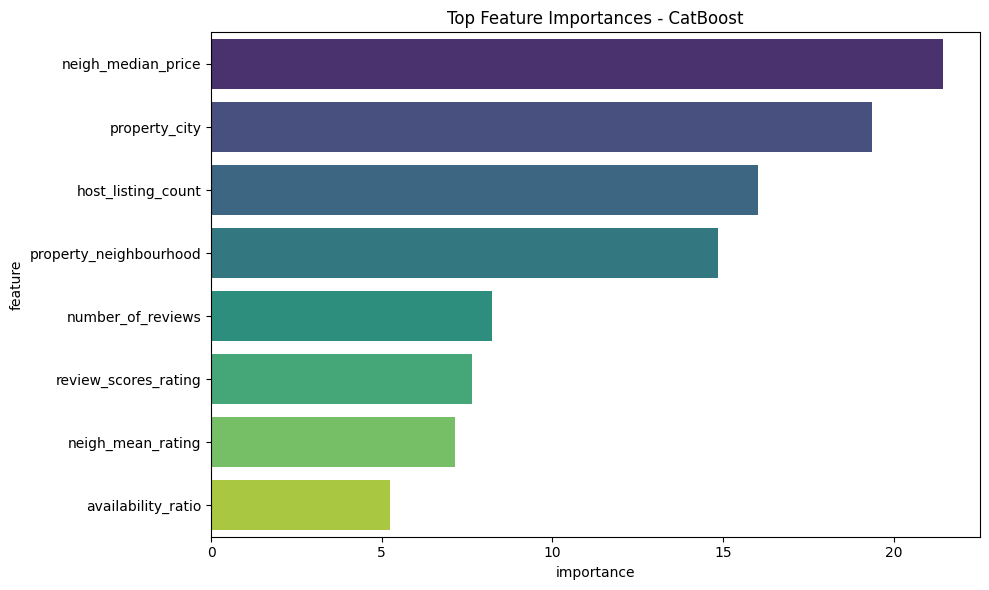


✅ Model Comparison:
      Model        R2  RMSE_log  RMSE_price
0   XGBoost  0.542489  0.526833  134.062893
1  LightGBM  0.501140  0.550125  138.998553
2  CatBoost  0.504640  0.548191  138.727185


In [ ]:
# ------------------------------------------------------------
# 1️⃣ Data Preparation
# ------------------------------------------------------------
df = df_filtered.copy()

# Target: Log-transform base price to stabilize variance
df['log_base_price'] = np.log1p(df['base_price'])

# Ensure consistent ID and categorical types
df['host_id'] = df['host_id'].astype('int64', errors='ignore')
df['listing_id'] = df['listing_id'].astype('int64', errors='ignore')
df['property_neighbourhood'] = df['property_neighbourhood'].astype(str)

# ------------------------------------------------------------
# Neighborhood-level Aggregates
# ------------------------------------------------------------
neigh_agg = df.groupby('property_neighbourhood').agg({
    'base_price': ['median', 'mean', 'std'],
    'review_scores_rating': ['mean', 'count'],
    'availability_ratio': 'mean'
}).reset_index()

neigh_agg.columns = [
    'property_neighbourhood',
    'neigh_median_price', 'neigh_mean_price', 'neigh_price_std',
    'neigh_mean_rating', 'neigh_review_count', 'neigh_avail_ratio'
]

# Drop old neighborhood columns if they exist
neigh_cols = [
    'neigh_median_price', 'neigh_mean_price', 'neigh_price_std',
    'neigh_mean_rating', 'neigh_review_count', 'neigh_avail_ratio'
]
df = df.drop(columns=[c for c in neigh_cols if c in df.columns], errors='ignore')

# Merge neighborhood aggregates
df = df.merge(neigh_agg, on='property_neighbourhood', how='left')

# ------------------------------------------------------------
# Host-level Aggregates (keep only count)
# ------------------------------------------------------------
host_agg = df.groupby('host_id').agg({
    'listing_id': 'count'   # only keep number of listings per host
}).reset_index()

host_agg.columns = ['host_id', 'host_listing_count']

# Merge back to main dataframe
df = df.merge(host_agg, on='host_id', how='left')

# ------------------------------------------------------------
# 2️⃣ Encode Categorical Variables with Target Encoding
# ------------------------------------------------------------
cat_cols = ['property_city', 'property_neighbourhood']

te = TargetEncoder(cols=cat_cols)
df[cat_cols] = te.fit_transform(df[cat_cols], df['log_base_price'])

# ------------------------------------------------------------
# 3️⃣ Prepare Features and Target
# ------------------------------------------------------------
features = [
    'review_scores_rating', 'availability_ratio',
    'neigh_median_price', 'neigh_mean_rating', 'number_of_reviews',
    'property_city', 'property_neighbourhood',
    'host_listing_count'
]

X = df[features].fillna(0)
y = df['log_base_price']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------------------------------------
# 4️⃣ Define Models
# ------------------------------------------------------------
models = {
    "XGBoost": XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=10,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=10,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    ),
    "CatBoost": CatBoostRegressor(
        iterations=500, learning_rate=0.05, depth=10,
        random_seed=42, verbose=100
    )
}

# ------------------------------------------------------------
# 5️⃣ Train & Evaluate
# ------------------------------------------------------------
results = []

for name, model in models.items():
    print(f"\n🚀 Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute metrics
    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_price = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
    r2 = r2_score(y_test, y_pred)

    results.append([name, r2, rmse_log, rmse_price])

    # --- Feature Importance
    importance = (
        model.feature_importances_ if hasattr(model, "feature_importances_")
        else model.get_feature_importance()
    )

    feat_imp = pd.DataFrame({
        'feature': X.columns,
        'importance': importance
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feat_imp.head(10), palette='viridis')
    plt.title(f"Top Feature Importances - {name}")
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# 6️⃣ Summary of Results
# ------------------------------------------------------------
results_df = pd.DataFrame(results, columns=['Model', 'R2', 'RMSE_log', 'RMSE_price'])
print("\n✅ Model Comparison:")
print(results_df)

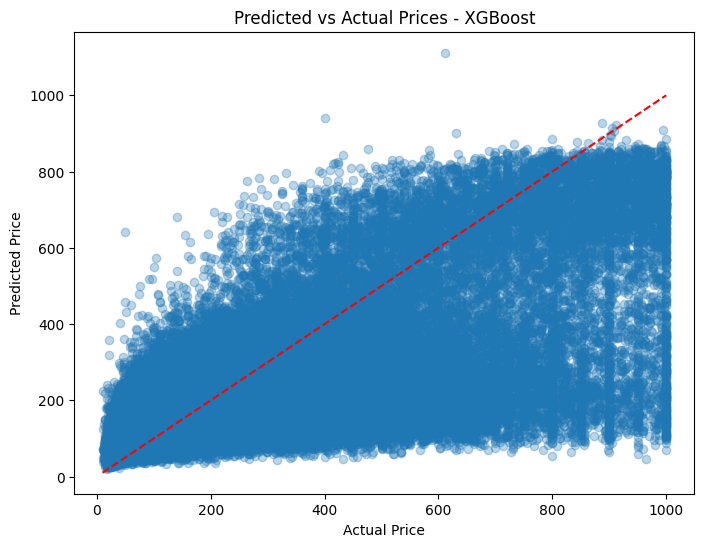

In [153]:
y_true = np.expm1(y_test)
y_pred = np.expm1(models["XGBoost"].predict(X_test))

plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices - XGBoost")
plt.show()


🚀 Training XGBoost...


C:\Users\yassi\AppData\Local\Temp\ipykernel_13116\4059872008.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp.head(10), palette='viridis')


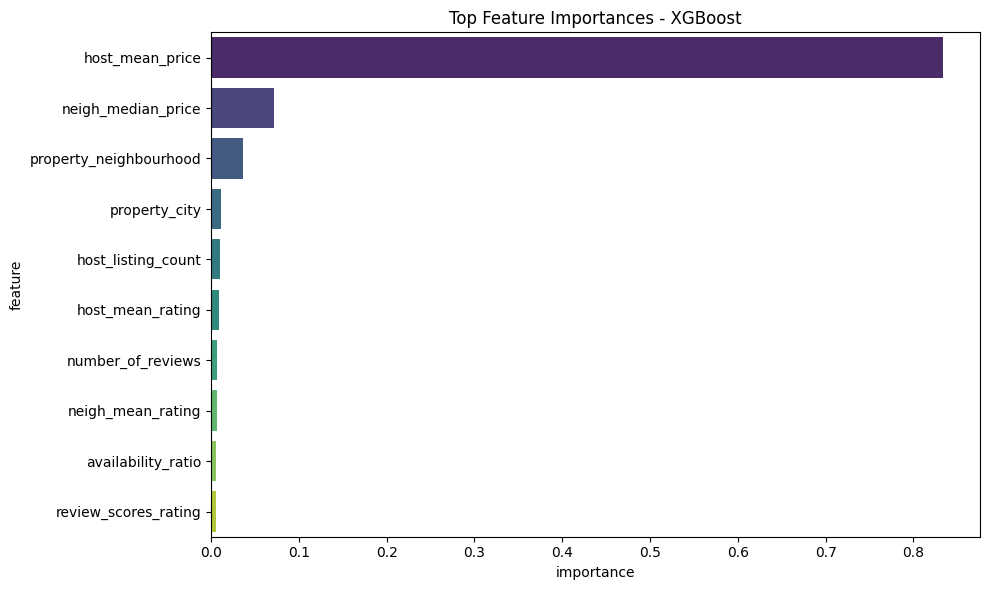


🚀 Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1857
[LightGBM] [Info] Number of data points in the train set: 634907, number of used features: 10
[LightGBM] [Info] Start training from score 5.049652


C:\Users\yassi\AppData\Local\Temp\ipykernel_13116\4059872008.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp.head(10), palette='viridis')


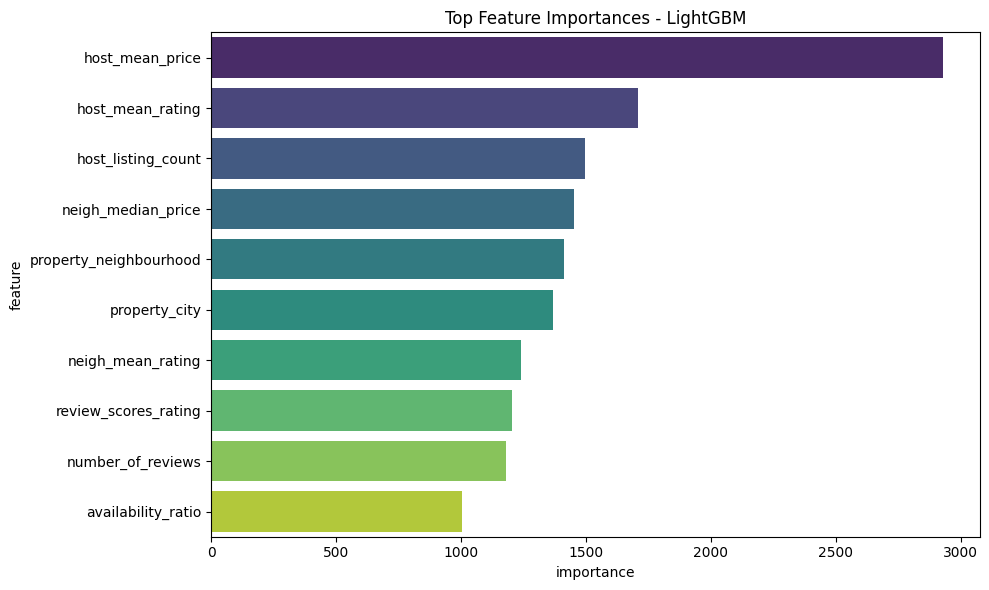


🚀 Training CatBoost...
0:	learn: 0.7469048	total: 55.7ms	remaining: 27.8s
100:	learn: 0.2700948	total: 5.16s	remaining: 20.4s
200:	learn: 0.2663687	total: 10.6s	remaining: 15.7s
300:	learn: 0.2639827	total: 16.1s	remaining: 10.6s
400:	learn: 0.2621165	total: 21.7s	remaining: 5.35s
499:	learn: 0.2603617	total: 27.3s	remaining: 0us


C:\Users\yassi\AppData\Local\Temp\ipykernel_13116\4059872008.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp.head(10), palette='viridis')


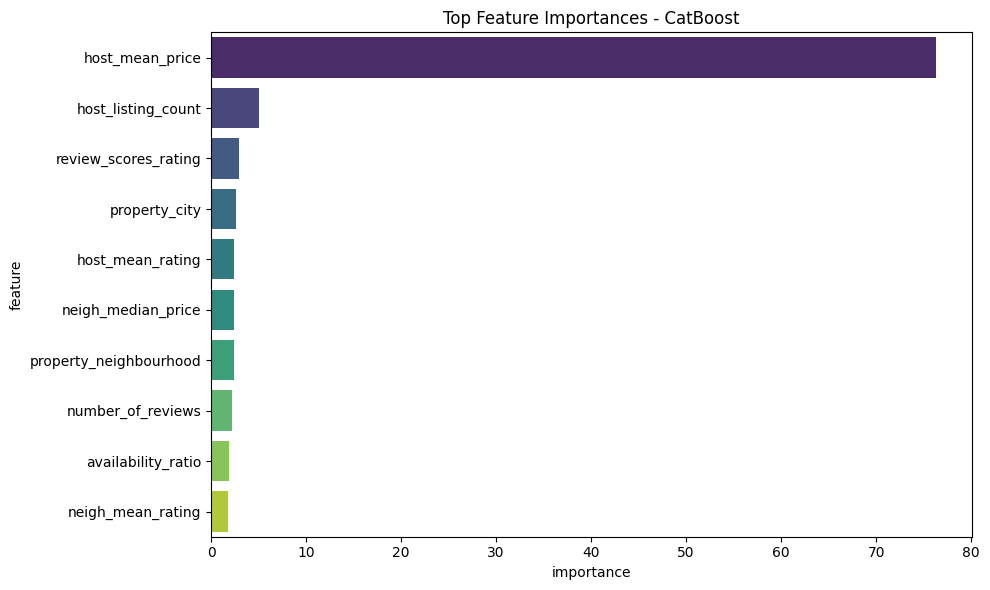


✅ Model Comparison:
      Model        R2  RMSE_log  RMSE_price
0   XGBoost  0.885170  0.263936   72.800331
1  LightGBM  0.881889  0.267680   73.112693
2  CatBoost  0.882733  0.266722   72.947101


In [141]:
# ------------------------------------------------------------
# 1️⃣ Data Preparation
# ------------------------------------------------------------
df = df_filtered.copy()

# Target: Log-transform base price to stabilize variance
df['log_base_price'] = np.log1p(df['base_price'])

# Ensure consistent ID and categorical types
df['host_id'] = df['host_id'].astype('int64', errors='ignore')
df['listing_id'] = df['listing_id'].astype('int64', errors='ignore')
df['property_neighbourhood'] = df['property_neighbourhood'].astype(str)

# ------------------------------------------------------------
# Neighborhood-level Aggregates
# ------------------------------------------------------------
neigh_agg = df.groupby('property_neighbourhood').agg({
    'base_price': ['median', 'mean', 'std'],
    'review_scores_rating': ['mean', 'count'],
    'availability_ratio': 'mean'
}).reset_index()

neigh_agg.columns = [
    'property_neighbourhood',
    'neigh_median_price', 'neigh_mean_price', 'neigh_price_std',
    'neigh_mean_rating', 'neigh_review_count', 'neigh_avail_ratio'
]

# Drop old neighborhood columns if they exist
neigh_cols = [
    'neigh_median_price', 'neigh_mean_price', 'neigh_price_std',
    'neigh_mean_rating', 'neigh_review_count', 'neigh_avail_ratio'
]
df = df.drop(columns=[c for c in neigh_cols if c in df.columns], errors='ignore')

# Merge neighborhood aggregates
df = df.merge(neigh_agg, on='property_neighbourhood', how='left')

# ------------------------------------------------------------
# Host-level Aggregates (smoothed)
# ------------------------------------------------------------
host_agg = df.groupby('host_id').agg({
    'base_price': 'mean',
    'review_scores_rating': 'mean',
    'listing_id': 'count'
}).reset_index()

host_agg.columns = ['host_id', 'host_mean_price', 'host_mean_rating', 'host_listing_count']

# Cap extreme values to reduce influence of super-hosts
host_agg['host_mean_price'] = host_agg['host_mean_price'].clip(
    upper=host_agg['host_mean_price'].quantile(0.99)
)
host_agg['host_listing_count'] = host_agg['host_listing_count'].clip(
    upper=host_agg['host_listing_count'].quantile(0.99)
)

# Merge back to main dataframe
df = df.merge(host_agg, on='host_id', how='left')

# ------------------------------------------------------------
# 2️⃣ Encode Categorical Variables with Target Encoding
# ------------------------------------------------------------
cat_cols = ['property_city', 'property_neighbourhood']

te = TargetEncoder(cols=cat_cols)
df[cat_cols] = te.fit_transform(df[cat_cols], df['log_base_price'])

# ------------------------------------------------------------
# 3️⃣ Prepare Features and Target
# ------------------------------------------------------------
features = [
    'review_scores_rating', 'availability_ratio',
    'neigh_median_price', 'neigh_mean_rating', 'number_of_reviews',
    'property_city', 'property_neighbourhood',
    'host_mean_price', 'host_mean_rating', 'host_listing_count'
]

X = df[features].fillna(0)
y = df['log_base_price']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------------------------------------
# 4️⃣ Define Models
# ------------------------------------------------------------
models = {
    "XGBoost": XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=10,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=10,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    ),
    "CatBoost": CatBoostRegressor(
        iterations=500, learning_rate=0.05, depth=10,
        random_seed=42, verbose=100
    )
}

# ------------------------------------------------------------
# 5️⃣ Train & Evaluate
# ------------------------------------------------------------
results = []

for name, model in models.items():
    print(f"\n🚀 Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute metrics
    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_price = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
    r2 = r2_score(y_test, y_pred)

    results.append([name, r2, rmse_log, rmse_price])

    # --- Feature Importance
    importance = (
        model.feature_importances_ if hasattr(model, "feature_importances_")
        else model.get_feature_importance()
    )

    feat_imp = pd.DataFrame({
        'feature': X.columns,
        'importance': importance
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feat_imp.head(10), palette='viridis')
    plt.title(f"Top Feature Importances - {name}")
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# 6️⃣ Summary of Results
# ------------------------------------------------------------
results_df = pd.DataFrame(results, columns=['Model', 'R2', 'RMSE_log', 'RMSE_price'])
print("\n✅ Model Comparison:")
print(results_df)



🚀 Training XGBoost with GroupKFold cross-validation...


C:\Users\yassi\AppData\Local\Temp\ipykernel_13116\1598890812.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp.head(10), palette='viridis')


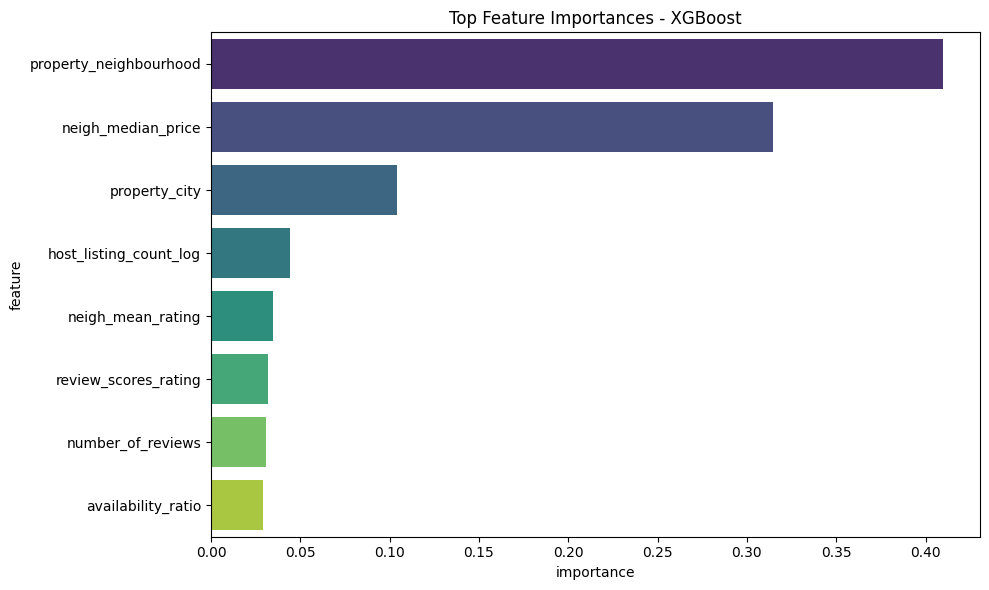


🚀 Training LightGBM with GroupKFold cross-validation...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1347
[LightGBM] [Info] Number of data points in the train set: 634907, number of used features: 8
[LightGBM] [Info] Start training from score 5.049001
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1345
[LightGBM] [Info] Number of data points in the train set: 634907, number of used features: 8
[LightGBM] [Info] Start training from score 5.047007
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004044 seconds.
You can set `force_row_wise

C:\Users\yassi\AppData\Local\Temp\ipykernel_13116\1598890812.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp.head(10), palette='viridis')


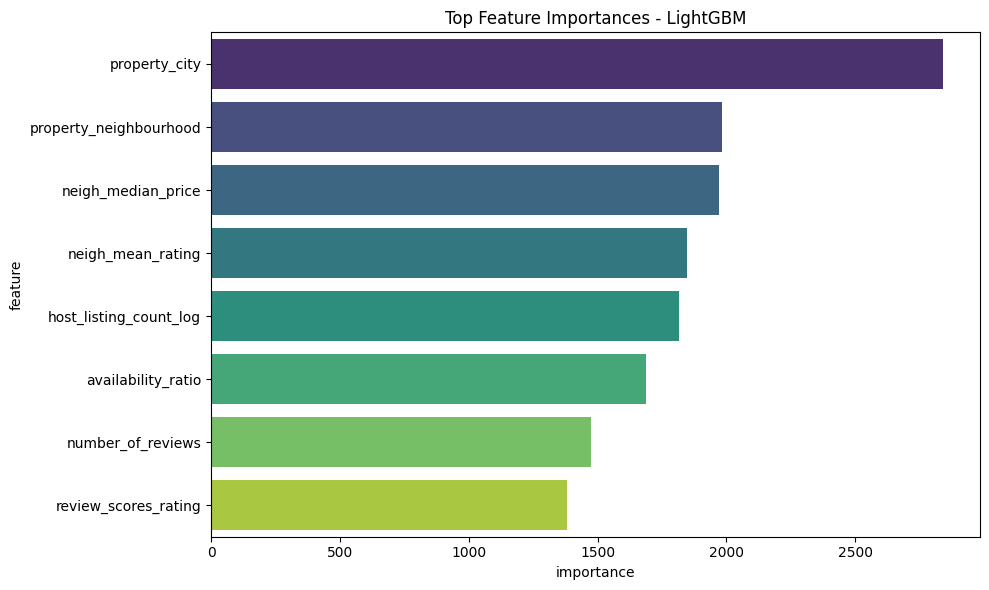


🚀 Training CatBoost with GroupKFold cross-validation...
0:	learn: 0.7635261	total: 49.5ms	remaining: 24.7s
100:	learn: 0.5664112	total: 4.74s	remaining: 18.7s
200:	learn: 0.5592215	total: 9.54s	remaining: 14.2s
300:	learn: 0.5546483	total: 14.2s	remaining: 9.39s
400:	learn: 0.5510319	total: 18.9s	remaining: 4.66s
499:	learn: 0.5479661	total: 23.5s	remaining: 0us
0:	learn: 0.7641219	total: 54.7ms	remaining: 27.3s
100:	learn: 0.5671030	total: 4.91s	remaining: 19.4s
200:	learn: 0.5599433	total: 9.66s	remaining: 14.4s
300:	learn: 0.5551416	total: 14.4s	remaining: 9.49s
400:	learn: 0.5515560	total: 19.1s	remaining: 4.71s
499:	learn: 0.5485237	total: 23.7s	remaining: 0us
0:	learn: 0.7633754	total: 47.3ms	remaining: 23.6s
100:	learn: 0.5670879	total: 4.84s	remaining: 19.1s
200:	learn: 0.5596560	total: 9.63s	remaining: 14.3s
300:	learn: 0.5547474	total: 14.4s	remaining: 9.54s
400:	learn: 0.5510196	total: 19.2s	remaining: 4.75s
499:	learn: 0.5480817	total: 24.1s	remaining: 0us
0:	learn: 0.7638

C:\Users\yassi\AppData\Local\Temp\ipykernel_13116\1598890812.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp.head(10), palette='viridis')


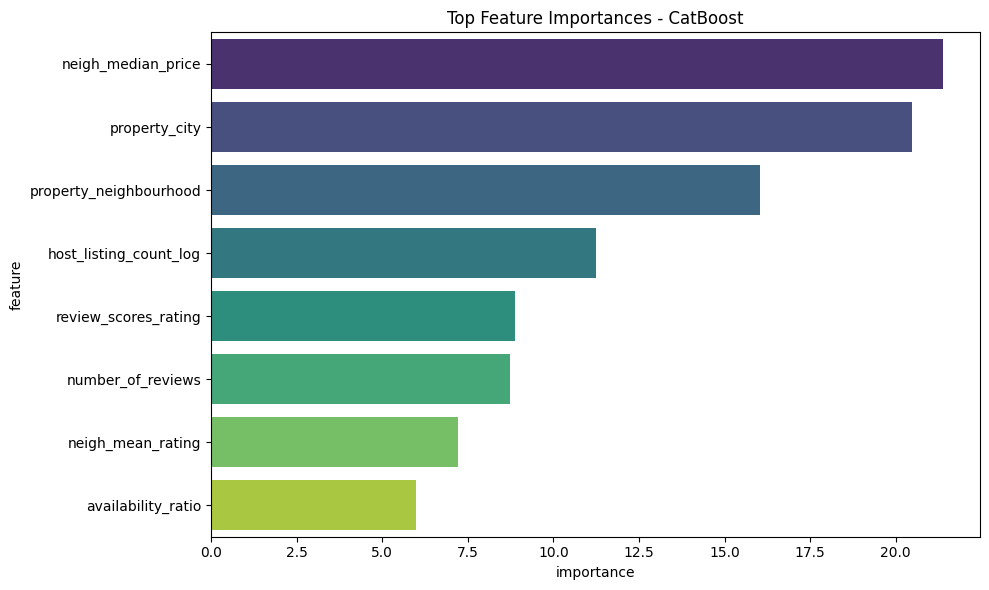


✅ Model Comparison (GroupKFold):
      Model   R2_mean  RMSE_log_mean  RMSE_price_mean
0   XGBoost  0.477030       0.563904       140.874804
1  LightGBM  0.476531       0.564173       141.818474
2  CatBoost  0.479799       0.562408       141.371281


In [142]:
# ------------------------------------------------------------
# 1️⃣ Data Preparation
# ------------------------------------------------------------
df = df_filtered.copy()

# Target: Log-transform base price to stabilize variance
df['log_base_price'] = np.log1p(df['base_price'])

# Ensure consistent ID and categorical types
df['host_id'] = df['host_id'].astype('int64', errors='ignore')
df['listing_id'] = df['listing_id'].astype('int64', errors='ignore')
df['property_neighbourhood'] = df['property_neighbourhood'].astype(str)

# ------------------------------------------------------------
# Neighborhood-level Aggregates
# ------------------------------------------------------------
neigh_agg = df.groupby('property_neighbourhood').agg({
    'base_price': ['median', 'mean', 'std'],
    'review_scores_rating': ['mean', 'count'],
    'availability_ratio': 'mean'
}).reset_index()

neigh_agg.columns = [
    'property_neighbourhood',
    'neigh_median_price', 'neigh_mean_price', 'neigh_price_std',
    'neigh_mean_rating', 'neigh_review_count', 'neigh_avail_ratio'
]

# Drop old neighborhood columns if they exist
neigh_cols = [
    'neigh_median_price', 'neigh_mean_price', 'neigh_price_std',
    'neigh_mean_rating', 'neigh_review_count', 'neigh_avail_ratio'
]
df = df.drop(columns=[c for c in neigh_cols if c in df.columns], errors='ignore')

# Merge neighborhood aggregates
df = df.merge(neigh_agg, on='property_neighbourhood', how='left')

# ------------------------------------------------------------
# Host-level Aggregates (safe & smoothed)
# ------------------------------------------------------------
host_agg = df.groupby('host_id').agg({
    'listing_id': 'count'
}).reset_index()

host_agg.columns = ['host_id', 'host_listing_count']

# Cap and log-transform to reduce influence of super-hosts
host_agg['host_listing_count'] = host_agg['host_listing_count'].clip(
    upper=host_agg['host_listing_count'].quantile(0.99)
)
host_agg['host_listing_count_log'] = np.log1p(host_agg['host_listing_count'])

# Merge back to main dataframe
df = df.merge(host_agg[['host_id', 'host_listing_count_log']], on='host_id', how='left')

# ------------------------------------------------------------
# 2️⃣ Encode Categorical Variables with Target Encoding
# ------------------------------------------------------------
cat_cols = ['property_city', 'property_neighbourhood']

te = TargetEncoder(cols=cat_cols)
df[cat_cols] = te.fit_transform(df[cat_cols], df['log_base_price'])

# ------------------------------------------------------------
# 3️⃣ Prepare Features and Target
# ------------------------------------------------------------
features = [
    'review_scores_rating', 'availability_ratio',
    'neigh_median_price', 'neigh_mean_rating',
    'number_of_reviews', 'property_city', 'property_neighbourhood',
    'host_listing_count_log'
]

X = df[features].fillna(0)
y = df['log_base_price']

# ------------------------------------------------------------
# 4️⃣ Define Models
# ------------------------------------------------------------
models = {
    "XGBoost": XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=10,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=10,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    ),
    "CatBoost": CatBoostRegressor(
        iterations=500, learning_rate=0.05, depth=10,
        random_seed=42, verbose=100
    )
}

# ------------------------------------------------------------
# 5️⃣ Train & Evaluate using GroupKFold (grouped by host)
# ------------------------------------------------------------
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=5)
results = []

for name, model in models.items():
    print(f"\n🚀 Training {name} with GroupKFold cross-validation...")

    fold_r2, fold_rmse_log, fold_rmse_price = [], [], []

    for train_idx, test_idx in gkf.split(X, y, groups=df['host_id']):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_price = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
        r2 = r2_score(y_test, y_pred)

        fold_r2.append(r2)
        fold_rmse_log.append(rmse_log)
        fold_rmse_price.append(rmse_price)

    results.append([
        name,
        np.mean(fold_r2),
        np.mean(fold_rmse_log),
        np.mean(fold_rmse_price)
    ])

    # --- Feature Importance (from last fold)
    importance = (
        model.feature_importances_ if hasattr(model, "feature_importances_")
        else model.get_feature_importance()
    )

    feat_imp = pd.DataFrame({
        'feature': X.columns,
        'importance': importance
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feat_imp.head(10), palette='viridis')
    plt.title(f"Top Feature Importances - {name}")
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# 6️⃣ Summary of Results
# ------------------------------------------------------------
results_df = pd.DataFrame(results, columns=['Model', 'R2_mean', 'RMSE_log_mean', 'RMSE_price_mean'])
print("\n✅ Model Comparison (GroupKFold):")
print(results_df)



🚀 Training XGBoost...


C:\Users\yassi\AppData\Local\Temp\ipykernel_13116\191189667.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp.head(10), palette='viridis')


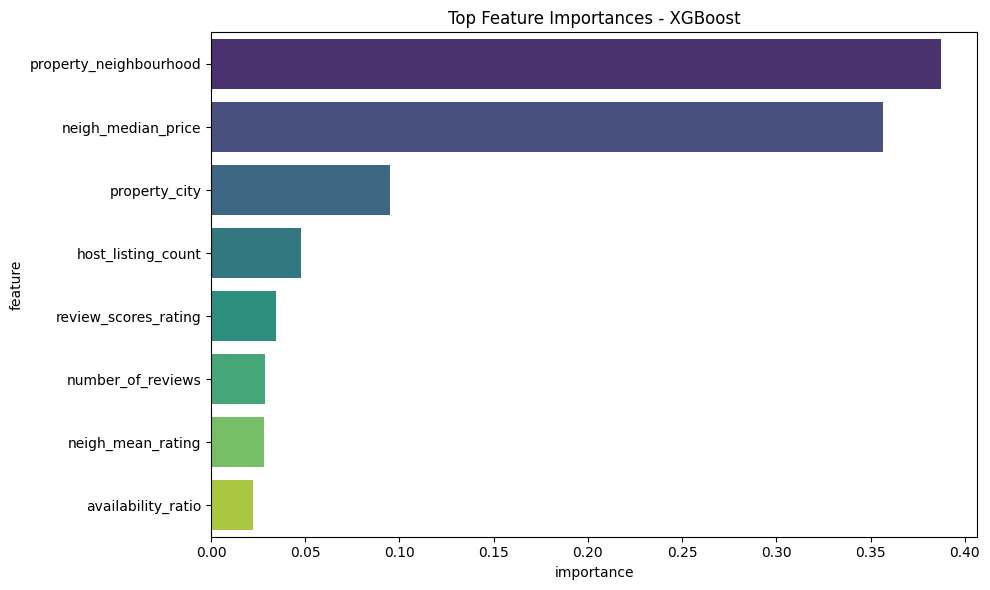


🚀 Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1566
[LightGBM] [Info] Number of data points in the train set: 634907, number of used features: 8
[LightGBM] [Info] Start training from score 5.049652


C:\Users\yassi\AppData\Local\Temp\ipykernel_13116\191189667.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp.head(10), palette='viridis')


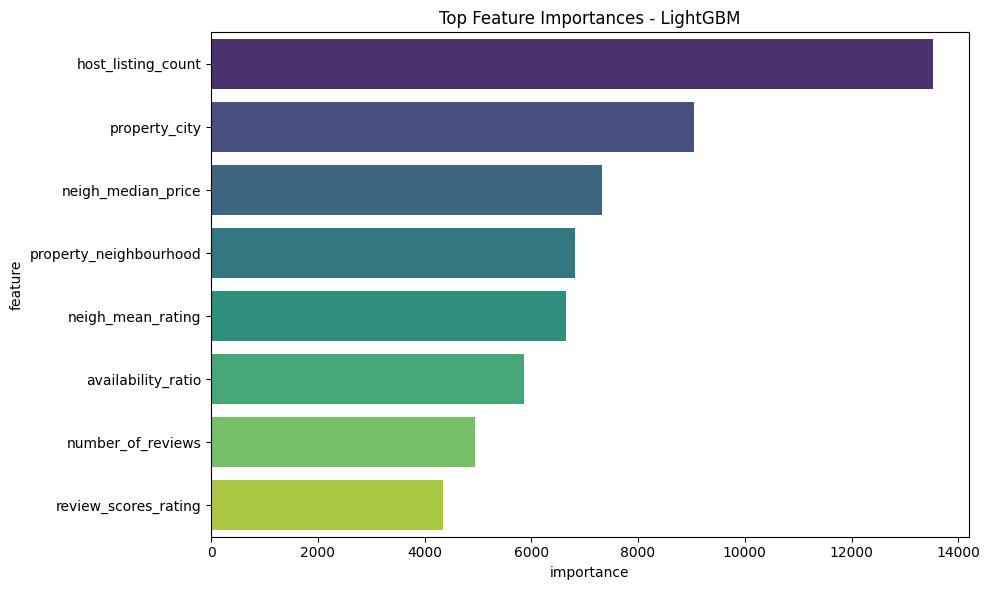


🚀 Training CatBoost...
0:	learn: 0.7704323	total: 49.2ms	remaining: 1m 13s
100:	learn: 0.5765009	total: 3.01s	remaining: 41.7s
200:	learn: 0.5681631	total: 5.98s	remaining: 38.6s
300:	learn: 0.5639598	total: 8.9s	remaining: 35.5s
400:	learn: 0.5608608	total: 11.8s	remaining: 32.3s
500:	learn: 0.5582138	total: 14.6s	remaining: 29.2s
600:	learn: 0.5559529	total: 17.5s	remaining: 26.1s
700:	learn: 0.5540441	total: 20.5s	remaining: 23.3s
800:	learn: 0.5522732	total: 23.3s	remaining: 20.4s
900:	learn: 0.5507862	total: 26.2s	remaining: 17.4s
1000:	learn: 0.5494414	total: 29.1s	remaining: 14.5s
1100:	learn: 0.5481714	total: 32.1s	remaining: 11.6s
1200:	learn: 0.5469465	total: 34.9s	remaining: 8.68s
1300:	learn: 0.5458895	total: 37.7s	remaining: 5.77s
1400:	learn: 0.5448440	total: 40.6s	remaining: 2.87s
1499:	learn: 0.5438152	total: 43.6s	remaining: 0us


C:\Users\yassi\AppData\Local\Temp\ipykernel_13116\191189667.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp.head(10), palette='viridis')


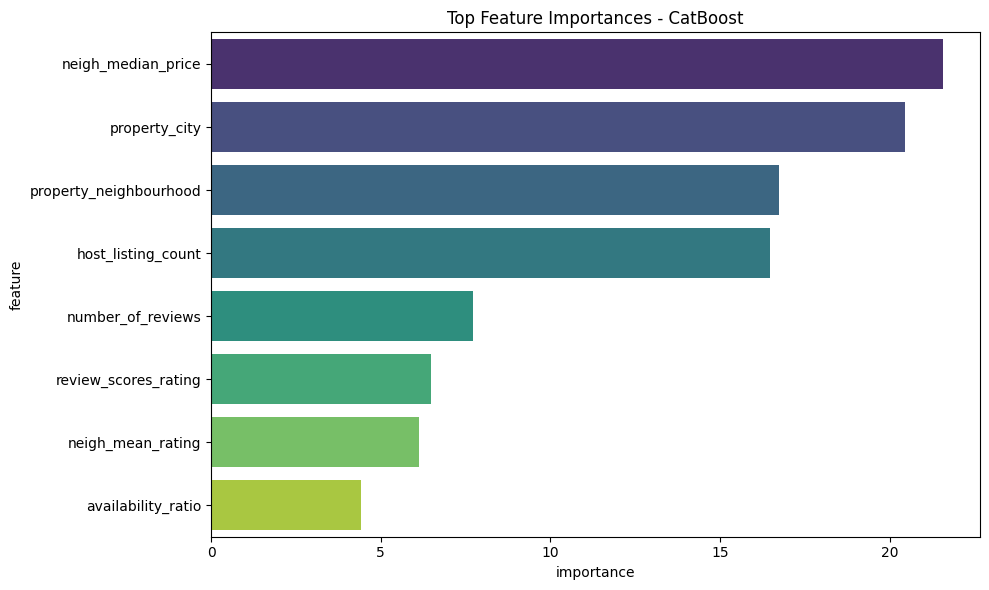


✅ Model Comparison:
      Model        R2  RMSE_log  RMSE_price
0   XGBoost  0.537920  0.529457  134.696063
1  LightGBM  0.513607  0.543207  137.594425
2  CatBoost  0.507050  0.546856  138.388580


In [143]:
# ------------------------------------------------------------
# 1️⃣ Data Preparation
# ------------------------------------------------------------
df = df_filtered.copy()

# Target: Log-transform base price to stabilize variance
df['log_base_price'] = np.log1p(df['base_price'])

# Ensure consistent ID and categorical types
df['host_id'] = df['host_id'].astype('int64', errors='ignore')
df['listing_id'] = df['listing_id'].astype('int64', errors='ignore')
df['property_neighbourhood'] = df['property_neighbourhood'].astype(str)

# ------------------------------------------------------------
# Neighborhood-level Aggregates
# ------------------------------------------------------------
neigh_agg = df.groupby('property_neighbourhood').agg({
    'base_price': ['median', 'mean', 'std'],
    'review_scores_rating': ['mean', 'count'],
    'availability_ratio': 'mean'
}).reset_index()

neigh_agg.columns = [
    'property_neighbourhood',
    'neigh_median_price', 'neigh_mean_price', 'neigh_price_std',
    'neigh_mean_rating', 'neigh_review_count', 'neigh_avail_ratio'
]

# Drop old neighborhood columns if they exist
neigh_cols = [
    'neigh_median_price', 'neigh_mean_price', 'neigh_price_std',
    'neigh_mean_rating', 'neigh_review_count', 'neigh_avail_ratio'
]
df = df.drop(columns=[c for c in neigh_cols if c in df.columns], errors='ignore')

# Merge neighborhood aggregates
df = df.merge(neigh_agg, on='property_neighbourhood', how='left')

# ------------------------------------------------------------
# Host-level Aggregates (keep only count)
# ------------------------------------------------------------
host_agg = df.groupby('host_id').agg({
    'listing_id': 'count'   # only keep number of listings per host
}).reset_index()

host_agg.columns = ['host_id', 'host_listing_count']

# Merge back to main dataframe
df = df.merge(host_agg, on='host_id', how='left')

# ------------------------------------------------------------
# 2️⃣ Encode Categorical Variables with Target Encoding
# ------------------------------------------------------------
cat_cols = ['property_city', 'property_neighbourhood']

te = TargetEncoder(cols=cat_cols)
df[cat_cols] = te.fit_transform(df[cat_cols], df['log_base_price'])

# ------------------------------------------------------------
# 3️⃣ Prepare Features and Target
# ------------------------------------------------------------
features = [
    'review_scores_rating', 'availability_ratio',
    'neigh_median_price', 'neigh_mean_rating', 'number_of_reviews',
    'property_city', 'property_neighbourhood',
    'host_listing_count'
]

X = df[features].fillna(0)
y = df['log_base_price']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------------------------------------
# 4️⃣ Define Models (Tuned Hyperparameters)
# ------------------------------------------------------------
models = {
    "XGBoost": XGBRegressor(
        n_estimators=1500,
        learning_rate=0.03,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.5,
        min_child_weight=5,
        random_state=42,
        n_jobs=-1
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=1500,
        learning_rate=0.03,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        num_leaves=40,
        random_state=42,
        n_jobs=-1
    ),
    "CatBoost": CatBoostRegressor(
        iterations=1500,
        learning_rate=0.03,
        depth=8,
        reg_lambda=1.2,
        random_seed=42,
        verbose=100
    )
}

# ------------------------------------------------------------
# 5️⃣ Train & Evaluate
# ------------------------------------------------------------
results = []

for name, model in models.items():
    print(f"\n🚀 Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute metrics
    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_price = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
    r2 = r2_score(y_test, y_pred)

    results.append([name, r2, rmse_log, rmse_price])

    # --- Feature Importance
    importance = (
        model.feature_importances_ if hasattr(model, "feature_importances_")
        else model.get_feature_importance()
    )

    feat_imp = pd.DataFrame({
        'feature': X.columns,
        'importance': importance
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feat_imp.head(10), palette='viridis')
    plt.title(f"Top Feature Importances - {name}")
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# 6️⃣ Summary of Results
# ------------------------------------------------------------
results_df = pd.DataFrame(results, columns=['Model', 'R2', 'RMSE_log', 'RMSE_price'])
print("\n✅ Model Comparison:")
print(results_df)


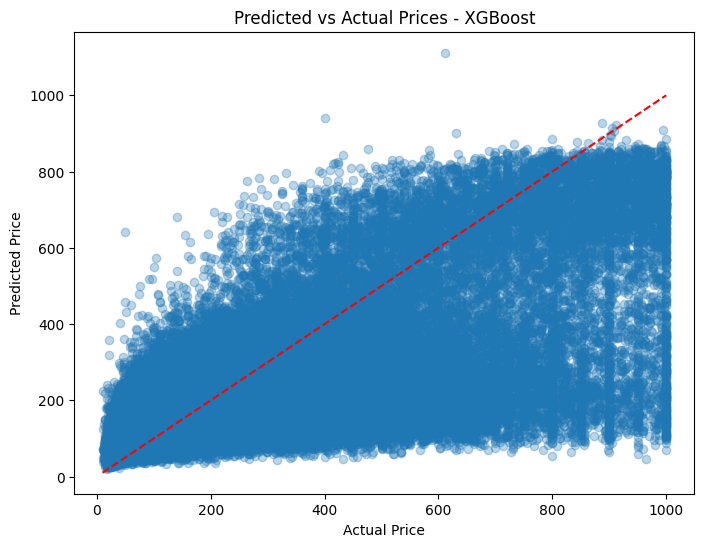

In [152]:
y_true = np.expm1(y_test)
y_pred = np.expm1(models["XGBoost"].predict(X_test))

plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices - XGBoost")
plt.show()


In [136]:
xgb_model = models["XGBoost"]
feat_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feat_imp.head(20))


                  feature  importance
7         host_mean_price    0.853712
2      neigh_median_price    0.059276
6  property_neighbourhood    0.035827
9      host_listing_count    0.010659
5           property_city    0.010198
8        host_mean_rating    0.008455
4       number_of_reviews    0.006029
3       neigh_mean_rating    0.005899
1      availability_ratio    0.005067
0    review_scores_rating    0.004878


R² Score: 0.884
RMSE (log-scale): 0.266
RMSE (original price): 73.09


C:\Users\yassi\AppData\Local\Temp\ipykernel_13116\491589705.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp.head(20), palette='viridis')


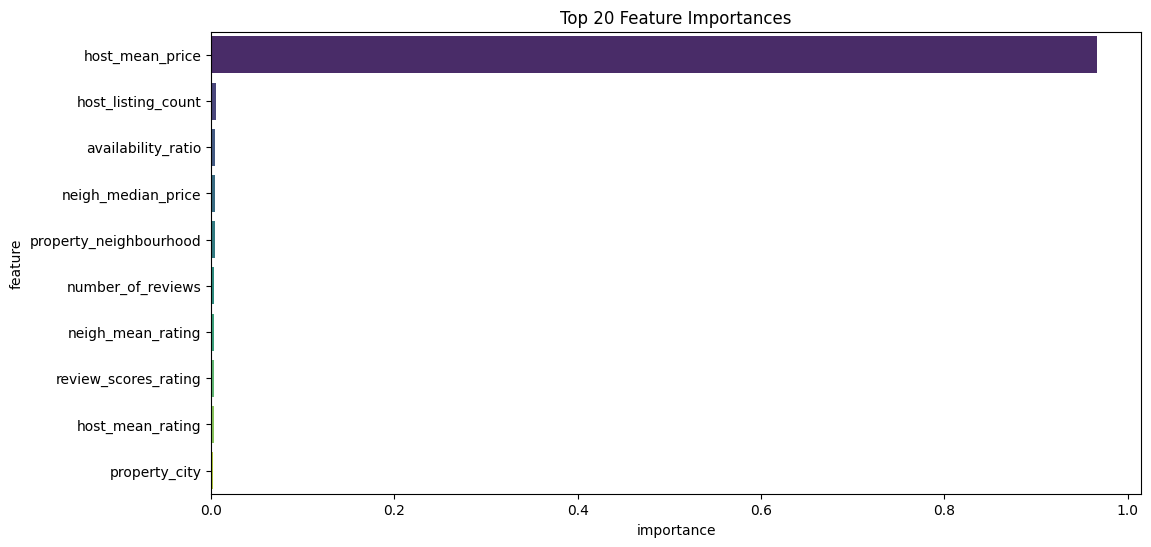

In [ ]:
# df = df_filtered.copy()

# # Log-transform target
# df['log_base_price'] = np.log1p(df['base_price']) 

# #Neighborhood-level aggregates
# # -------------------------------
# neigh_agg = df.groupby('property_neighbourhood').agg({
#     'base_price': ['median', 'mean', 'std'],
#     'review_scores_rating': ['mean', 'count'],
#     'availability_ratio': 'mean'
# }).reset_index()

# neigh_agg.columns = ['property_neighbourhood', 
#                      'neigh_median_price', 'neigh_mean_price', 'neigh_price_std',
#                      'neigh_mean_rating', 'neigh_review_count', 'neigh_available_ratio']

# df = df.merge(neigh_agg, on='property_neighbourhood', how='left')

# # -------------------------------
# # 4️⃣ Host-level aggregates
# # -------------------------------
# host_agg = df.groupby('host_id').agg({
#     'base_price': 'mean',
#     'review_scores_rating': 'mean',
#     'listing_id': 'count'
# }).reset_index()

# host_agg.columns = ['host_id', 'host_mean_price', 'host_mean_rating', 'host_listing_count']
# df = df.merge(host_agg, on='host_id', how='left')

# # -------------------------------
# # 5️⃣ Encode categorical features
# # -------------------------------
# cat_cols = ['property_city', 'property_neighbourhood']
# te = TargetEncoder(cols=cat_cols)
# df[cat_cols] = te.fit_transform(df[cat_cols], df['log_base_price'])

# # -------------------------------
# # 6️⃣ Prepare features & target
# # -------------------------------
# features = ['review_scores_rating', 'availability_ratio', 
#             'neigh_median_price', 'neigh_mean_rating', 'number_of_reviews',
#             'property_city', 'property_neighbourhood', 
#             'host_mean_price', 'host_mean_rating', 'host_listing_count']

# X = df[features].fillna(0)
# y = df['log_base_price']

# # -------------------------------
# # 7️⃣ Train/test split
# # -------------------------------
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # -------------------------------
# # 8️⃣ RandomForest Regression
# # -------------------------------
# rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, n_jobs=-1, random_state=42)
# rf_model.fit(X_train, y_train)

# y_pred = rf_model.predict(X_test)

# # -------------------------------
# # 9️⃣ Evaluation
# # -------------------------------
# rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
# rmse_price = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
# r2 = r2_score(y_test, y_pred)

# print(f"R² Score: {r2:.3f}")
# print(f"RMSE (log-scale): {rmse_log:.3f}")
# print(f"RMSE (original price): {rmse_price:.2f}")

# # -------------------------------
# # 🔟 Feature importance
# # -------------------------------
# feat_imp = pd.DataFrame({
#     'feature': X.columns,
#     'importance': rf_model.feature_importances_
# }).sort_values('importance', ascending=False)

# plt.figure(figsize=(12, 6))
# sns.barplot(x='importance', y='feature', data=feat_imp.head(20), palette='viridis')
# plt.title("Top 20 Feature Importances")
# plt.show()

In [104]:
# # -------------------------------
# # 1️⃣ Compute neighborhood-level aggregates
# # -------------------------------
# neigh_agg = df_model.groupby('property_neighbourhood').agg(
#     neigh_median_price=('base_price', 'median'),
#     neigh_mean_rating=('review_scores_rating', 'mean')
# ).reset_index()

# # Merge back to main dataframe
# df_model = df_model.merge(neigh_agg, on='property_neighbourhood', how='left')

# # -------------------------------
# # 2️⃣ Update features list
# # -------------------------------
# categorical_cols = ['property_city', 'property_neighbourhood']
# numeric_cols = ['review_scores_rating', 'availability_ratio', 'number_of_reviews',
#                 'neigh_median_price', 'neigh_mean_rating']

# features = numeric_cols + categorical_cols

# # -------------------------------
# # 3️⃣ Train/Test Split
# # -------------------------------
# X = df_model[features]
# y = np.log1p(df_model['base_price'])

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # -------------------------------
# # 4️⃣ Target Encoding
# # -------------------------------
# import category_encoders as ce
# encoder = ce.TargetEncoder(cols=categorical_cols)
# X_train_encoded = encoder.fit_transform(X_train, y_train)
# X_test_encoded = encoder.transform(X_test)

# # -------------------------------
# # 5️⃣ Train RandomForest
# # -------------------------------
# from sklearn.ensemble import RandomForestRegressor
# rf = RandomForestRegressor(n_estimators=200, max_depth=15, n_jobs=-1, random_state=42)
# rf.fit(X_train_encoded, y_train)

# # -------------------------------
# # 6️⃣ Evaluate
# # -------------------------------
# from sklearn.metrics import r2_score, mean_squared_error
# y_pred = rf.predict(X_test_encoded)

# r2 = r2_score(y_test, y_pred)
# rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f"R² Score: {r2:.3f}")
# print(f"RMSE (log-scale): {rmse_log:.3f}")

# # Convert back to original price scale
# y_test_exp = np.expm1(y_test)
# y_pred_exp = np.expm1(y_pred)
# rmse_orig = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
# print(f"RMSE (original price): {rmse_orig:.2f}")


In [105]:
# # Assuming your model is called rf_model and features are in X
# feature_importances = pd.DataFrame({
#     'feature': X.columns,
#     'importance': rf.feature_importances_
# })

# # Sort by importance
# feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# # Show top 20 features
# print(feature_importances.head(20))

# # Plot top 20
# sns.barplot(
#     x='importance', 
#     y='feature', 
#     data=feature_importances.head(20), 
#     hue='feature',   # assign y to hue
#     dodge=False,     # avoid splitting bars
#     legend=False     # hide legend
# )
# plt.title("Top 20 Feature Importances")
# plt.show()